# XML gaze data to pandas data and figures

## Import XML to dict

In [1]:
#additional helpful source:
#http://docs.python-guide.org/en/latest/scenarios/xml/

import xmltodict
import pandas as pd

In [2]:
filepath = 'data_1_24_2018_11_25_05_AM_corrected.xml'

with open(filepath) as fd:
    xml = xmltodict.parse(fd.read())

In [3]:
# #https://stackoverflow.com/questions/5071420/expat-based-xml-parsing-script-not-working-on-linux-work-on-windows
# document_file = open("data_1_24_2018_11_25_05_AM.xml", "r") # Open a file in read-only mode
# original_doc = document_file.read() # read the file object
# document = xmltodict.parse(original_doc) # Parse the read document string

In [4]:
'''Check the data structure'''
xml['Data']['Gaze'][0]

OrderedDict([(u'Left',
              OrderedDict([(u'Ray',
                            OrderedDict([(u'@PupilSize', u'0000.00238060'),
                                         (u'@valid', u'True'),
                                         (u'@timestamp',
                                          u'78975859099')]))]))])

In [5]:
'''Check the data structure'''
xml['Data']['GazePointCombined'][0]

OrderedDict([(u'@GazePointUnity',
              u'(0000.00000000, 0000.00000000, -0000.78000000)'),
             (u'@GazePointTobii',
              u'(-0000.01689851, 0001.24260700, -0002.57981500)'),
             (u'@TargetPosition',
              u'(0000.00000000, 0001.28000000, -0004.57000000)'),
             (u'@HeadPosition',
              u'(-0000.01523835, 0001.23875400, -0002.60477600)'),
             (u'@HeadRotation',
              u'(-0000.03917543, 0000.99902360, 0000.02023204, 0000.00278823)')])

In [6]:
len(xml['Data']['StageType']), len(xml['Data']['GazePointCombined'])

(29984, 29984)

In [7]:
xml['Data']['StageType'][0], xml['Data']['GazePointCombined'][0]

(OrderedDict([(u'@stage', u'0'), (u'@type', u'2')]),
 OrderedDict([(u'@GazePointUnity',
               u'(0000.00000000, 0000.00000000, -0000.78000000)'),
              (u'@GazePointTobii',
               u'(-0000.01689851, 0001.24260700, -0002.57981500)'),
              (u'@TargetPosition',
               u'(0000.00000000, 0001.28000000, -0004.57000000)'),
              (u'@HeadPosition',
               u'(-0000.01523835, 0001.23875400, -0002.60477600)'),
              (u'@HeadRotation',
               u'(-0000.03917543, 0000.99902360, 0000.02023204, 0000.00278823)')]))

## Dict to pandas

In [12]:
len(xml['Data']['StageType'][:50])

50

In [27]:
'''Read attributes to pandas format'''

gazes = xml['Data']
n = 10000
df = pd.DataFrame()

for i in xrange(len(xml['Data']['StageType'][:n])):
    df.loc[i,'gpu_x'] = gazes['GazePointCombined'][i]['@GazePointUnity'][1:-2].split(",")[0] 
    df.loc[i,'gpu_y'] = gazes['GazePointCombined'][i]['@GazePointUnity'][1:-2].split(",")[1]
    df.loc[i,'gpu_z'] = gazes['GazePointCombined'][i]['@GazePointUnity'][1:-2].split(",")[2]
    df.loc[i,'stage'] = gazes['StageType'][i]['@stage']
    df.loc[i,'type'] = gazes['StageType'][i]['@type']
    i +=1

print i

10000


In [28]:
df.head()

,gpu_x,gpu_y,gpu_z,stage,type
0,0000.00000000,0000.00000000,-0000.7800000,0,2
1,0000.00000000,0000.00000000,-0000.7800000,0,2
2,0000.00000000,0000.00000000,-0000.7800000,0,2
3,0000.00000000,0000.00000000,-0000.7800000,0,2
4,0000.00000000,0000.00000000,-0000.7800000,0,2


In [29]:
'''Short check'''
df.head(2)

,gpu_x,gpu_y,gpu_z,stage,type
0,0000.00000000,0000.00000000,-0000.7800000,0,2
1,0000.00000000,0000.00000000,-0000.7800000,0,2


In [30]:
df.tail(2)

,gpu_x,gpu_y,gpu_z,stage,type
9998,0003.34571700,0000.12580310,-0006.2127690,1,2
9999,0003.34571700,0000.12580310,-0006.2127690,1,2


In [31]:
'''Check the length and data format'''
len(df), type(df.gpu_x[0])

(10000, unicode)

## Data massage

In [32]:
# '''Remove Nan'''
# df=df[df.left_ox!='NaN']

In [33]:
# '''Check that there are no NaN'''
# df.tail(2)

In [34]:
'''Remove extra white space and cpnvert to float format'''
cols = [i for i in df.columns]
df[cols] = df[cols].replace(' ','').astype(float)

In [35]:
'''Normed z value: inverse of (min-max scaling + .1)
.1 added to avoid 0'''
norm = lambda x: 1/(((x - x.min()) / (x.max()-x.min()))+.1)
df['gpu_nz'] = df['gpu_y'].transform(norm)

In [36]:
df['gpu_nz'].min(), df['gpu_nz'].max()

(0.90909090909090906, 10.0)

## Figures

In [37]:
import seaborn as sns
sns.set(style="white", color_codes=True)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

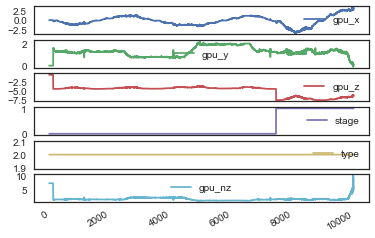

In [38]:
'''Just out of curiosity'''
df.plot(subplots=True);

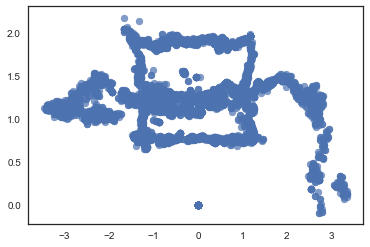

In [39]:
'''Left direction'''
plt.scatter(df['gpu_x'], df['gpu_y'], alpha=.7)

### Plot x and y

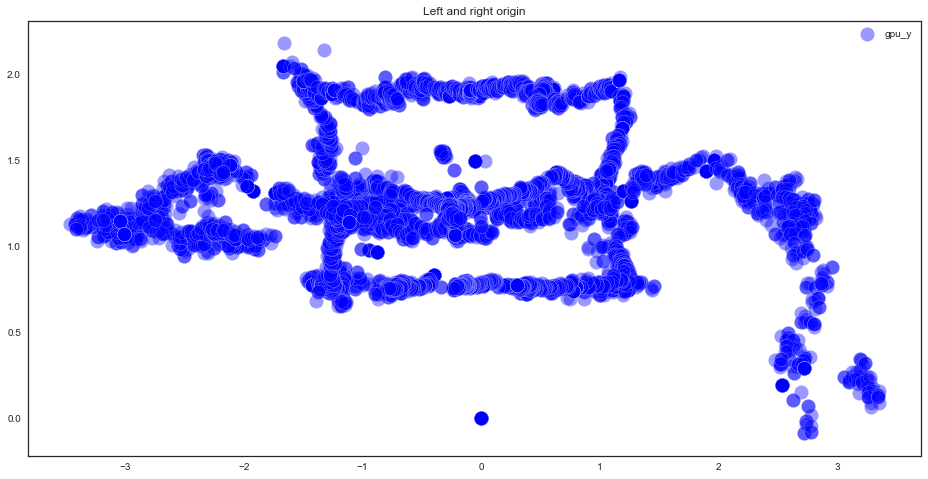

In [41]:
data = (['gpu'])
colors = (["blue"])
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = df[data+'_x']
    y = df[data+'_y']
    ax.scatter(x, y, alpha=0.4, c=color, edgecolors='w', s=200)
 
plt.title('Left and right origin')
plt.legend(loc=1)
plt.savefig('gaze_data2_origin.png', format='png', dpi=300);

### Plot x, y, z
z visualized as the point size

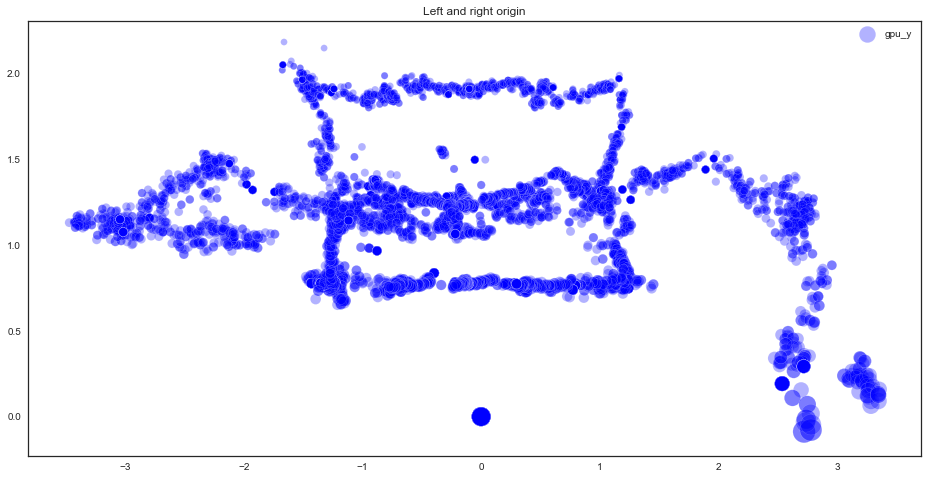

In [42]:
data = (['gpu'])
colors = (["blue"])
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = df[data+'_x']
    y = df[data+'_y']
    z = df[data+'_nz']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=50*z)
 
plt.title('Gaze')
plt.legend(loc=1)
plt.savefig('gaze_data2_origin_z.png', format='png', dpi=300);